In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy import stats
from sklearn import linear_model
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline
train = pd.read_csv('train.csv')
train_sample = train.sample(train.shape[0]/2)
test = pd.read_csv('test.csv')

In [2]:
def remove_nas(dataframe, percent):
    null_data = dataframe.isnull().sum()
    data_to_remove = null_data[null_data > dataframe.shape[0]*percent].index.tolist()
    dataframe.drop(data_to_remove,1, inplace=True)
    return dataframe

In [3]:
def int_data(dataframe):
    data_type = dataframe.dtypes
    int_columns_1 = data_type[data_type=='int64'].index.tolist()
    int_columns_2 = data_type[data_type=='float64'].index.tolist()
    int_columns = int_columns_1 + int_columns_2
    int_dataframe = dataframe[int_columns]
    return int_dataframe

In [4]:
def process_data(dataframe):
    dataframe['TotalSF'] = dataframe['1stFlrSF'] + dataframe['2ndFlrSF']+ dataframe['TotalBsmtSF']
    dataframe.drop(['1stFlrSF', '2ndFlrSF', 'TotalBsmtSF'],1, inplace=True)
    return dataframe

def graph_processed_data(dataframe):
    var = [e for e in dataframe.columns.values.tolist() if e not in ('Id', 'SalePrice')]
    num_col = dataframe[var].shape[1]
    graph_dimension = int(round(math.sqrt(num_col)))

    f, ax = plt.subplots(graph_dimension, graph_dimension,figsize=(18,12))
    plt.subplots_adjust( hspace=0.3 )
    plt.subplots_adjust( wspace=0.04 )

    y = dataframe['SalePrice']
    counter = 0

    list_of_predictors =[]
    
    independent_var = dataframe[var]

    for i in range(graph_dimension):
        for j in range(graph_dimension):
            ax[i][j].get_yaxis().set_ticks([])
            ax[i][j].get_xaxis().set_ticks([])
            if counter >= num_col:
                continue
            else:
                x = independent_var.iloc[:, counter]
                ax[i][j].scatter(x,y)
                ax[i][j].set_title(independent_var.columns.values[counter])
            
                slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
            
                if r_value**2 > 0.3:
                    list_of_predictors.append(independent_var.columns.values[counter])
                counter = counter + 1

    final_int_train = independent_var[list_of_predictors]
    return list_of_predictors, dataframe, final_int_train


In [5]:
def categorical_data(dataframe):
    dtype = dataframe.dtypes
    categories = dtype[dtype == 'object'].index.tolist()
    category_dataframe = dataframe[categories]
    return category_dataframe

/home/jen/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/jen/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


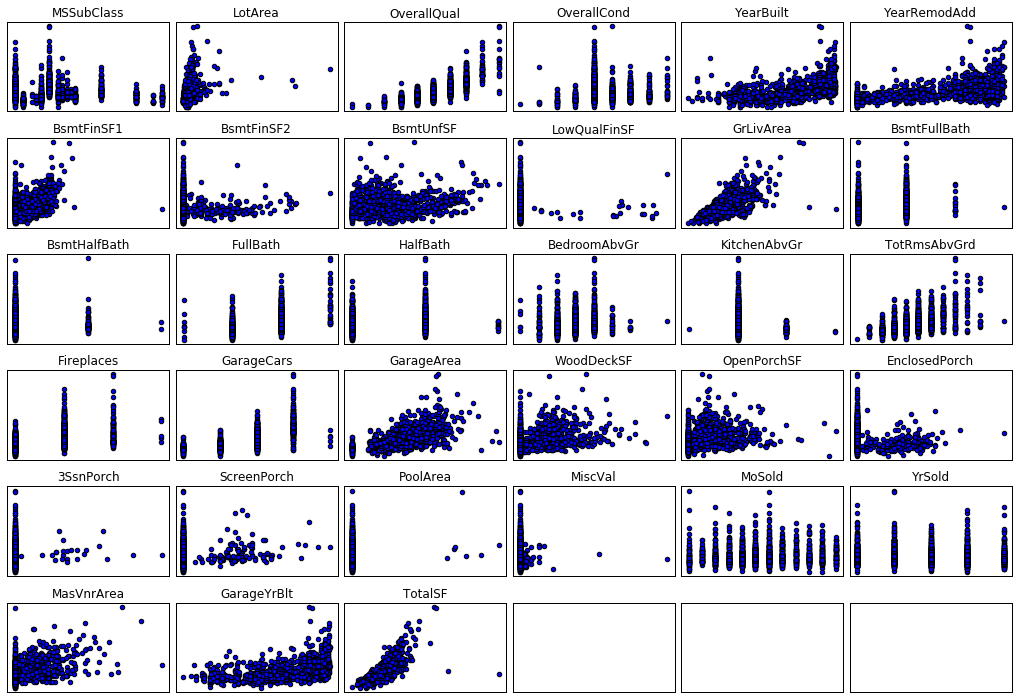

In [6]:
no_na_train = remove_nas(train, .10)
numerical_train = int_data(no_na_train)
process_train = process_data(numerical_train)
list_of_predictors_train, train, final_int_train = graph_processed_data(process_train)

In [7]:
cat = categorical_data(no_na_train)
cat = pd.get_dummies(cat)
cat['SalePrice']= no_na_train['SalePrice']
category_list = cat.columns.values.tolist()
sig_list = []
for c in category_list[:-1]:
    neg = cat['SalePrice'][cat[c] == 0].tolist()
    pos = cat['SalePrice'][cat[c] == 1].tolist()
    f_val, p_val = stats.kruskal(neg, pos)
    if p_val <= 0.005:
        sig_list.append(c)
        
final_cat_train = cat[sig_list]

In [8]:
no_na_test = remove_nas(test, .10)
numerical_test = int_data(no_na_test)
process_test = process_data(numerical_test)
cat_test = categorical_data(no_na_test)
cat_test = pd.get_dummies(cat_test)
cat_test_final = cat_test[sig_list]

/home/jen/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/jen/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [9]:
final_train = pd.concat([final_int_train,final_cat_train], axis = 1)


/home/jen/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=10.
  % (min_labels, self.n_folds)), Warning)


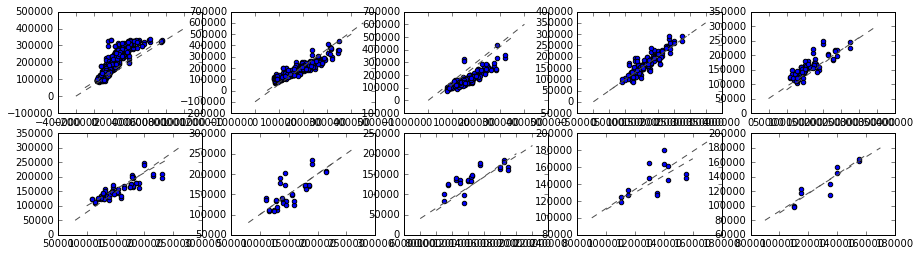

In [10]:
x_train, x_test, y_train, y_test = train_test_split(final_train.values, train['SalePrice'].as_matrix(), test_size=0.3)
k_fold = StratifiedKFold(y_train.ravel(), n_folds=10)

lr = RandomForestRegressor()
lr.fit(x_train,y_train.ravel().T)


times=2

f, ax = plt.subplots(2,5,figsize=(15, 4))

for i in range(times):
    counter = 0
    for train_indx, test_indx in k_fold:
        val_train_x, val_train_y =x_train[train_indx], y_train[train_indx]
        val_test_x, val_test_y = x_train[test_indx], y_train[test_indx]
        lr.fit(val_train_x, val_train_y.ravel().T)
        y_pred = lr.predict(val_test_x)
        ax[counter/5][counter % 5].scatter(val_test_y, y_pred)
        ax[counter/5][counter % 5].plot(ax[counter/5][counter % 5].get_xlim(), ax[counter/5][counter % 5].get_ylim(), ls="--", c=".3")
        counter += 1

In [11]:
process_test.fillna(process_test.mean(), inplace=True)
dtype_test=process_test[list_of_predictors_train].dtypes
floats= dtype_test[dtype_test=='float64'].index.tolist()
process_test[floats].astype(int)
final_test = pd.concat([process_test[list_of_predictors_train], cat_test_final], axis = 1)

/home/jen/anaconda2/lib/python2.7/site-packages/pandas/core/frame.py:2756: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


ValueError: Cannot convert NA to integer

In [ ]:
pred_t = lr.predict(final_test)
output = process_test[['Id']]
output['SalePrice']=pred_t
output = output.applymap(abs)
output.to_csv("prediction2.csv",index=False)

In [ ]:
pred = pd.read_csv('prediction.csv')
pred.shape